In [1]:
%load_ext lab_black
%cd ..

/home/shim/cev/dl/motion-keypoint


In [2]:
import argparse, random
import multiprocessing
import json
import math
import sys
from dataclasses import dataclass
from pathlib import Path
from pprint import pformat

import cv2
import imageio
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from easydict import EasyDict
from PIL import Image
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

import networks
import options
import utils
from datasets import get_pose_datasets, TestKeypointDataset, KeypointDataset
from losses import AWing, JointMSELoss, KeypointBCELoss, KeypointLoss, KeypointRMSE, SigmoidMAE, SigmoidKLDivLoss
from importlib import import_module
from error_list import error_list

import pandas as pd

## 모델 로딩

In [3]:
with open("config/hrnet-w48-train-ce-512x512.yaml", "r") as f:
    C = EasyDict(yaml.load(f, yaml.FullLoader))

    if C.dataset.num_cpus < 0:
        C.dataset.num_cpus = multiprocessing.cpu_count()

    C.result_dir = Path(C.result_dir)
    C.dataset.train_dir = Path(C.dataset.train_dir)
    utils.seed_everything(C.seed, deterministic=False)

In [4]:
main = import_module("main-hrnet-train")

In [5]:
trainer = main.PoseTrainer(C, 1, "results/hrnet-train2/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau_4.pth")

Load pretrained results/hrnet-train2/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau_4.pth


In [6]:
model = trainer.pose_model
model.eval()
torch.set_grad_enabled(False)

In [7]:
img_files = sorted(list(Path("data/ori/test_imgs/").glob("*.jpg")))
# img_files = sorted(list(Path("results/effdet-train/example/efficientdet-d7_multi5_flip_median_test_imgs/").glob("*.jpg")))
info_file = Path("results/effdet-train/example/efficientdet-d7_multi5_flip_median_test_imgs/info.json")

In [8]:
with open(info_file, "r") as f:
    info = json.load(f)

In [9]:
info[0]

{'file': '649-2-4-32-Z148_A-0000001.jpg',
 'roi': [654.6475219726562,
  259.51214599609375,
  1187.3297119140625,
  729.2205810546875]}

In [10]:
sizes = [(256, 256), (512, 512), (768, 768)]
rotations = [0, 1, 2, 3]
vflips = [False, True]
hflips = [False, True]

ds_tests = [
    TestKeypointDataset(
        img_files,
        info,
        normalize=True,
        mean=C.dataset.mean,
        std=C.dataset.std,
        size=size,
        rotation=rotation,
        horizontal_flip=hflip,
        vertical_flip=vflip,
        ratio_limit=C.dataset.ratio_limit,
    )
    for size in sizes
    for rotation in rotations
    for vflip in vflips
    for hflip in hflips
]
len(ds_tests)

48

In [11]:
L = len(ds_tests[0])
L

1600

In [12]:
denormalize = utils.Tensor2Image(mean=C.dataset.mean, std=C.dataset.std)

In [13]:
i = 0

In [14]:
ds_tests[0][i]

('data/ori/test_imgs/649-2-4-32-Z148_A-0000001.jpg',
 tensor([[[ 1.2288,  1.2299,  1.2416,  ...,  1.5098,  1.5098,  1.5226],
          [ 1.2288,  1.2288,  1.2291,  ...,  1.5098,  1.5098,  1.5226],
          [ 1.2288,  1.2288,  1.2288,  ...,  1.5098,  1.5098,  1.5226],
          ...,
          [-0.7297, -0.7425, -0.7425,  ..., -0.6148, -0.6110, -0.6107],
          [-0.7404, -0.7532, -0.7532,  ..., -0.6234, -0.6234, -0.6234],
          [-0.7639, -0.7512, -0.7512,  ..., -0.5979, -0.6096, -0.6107]],
 
         [[ 1.2282,  1.2294,  1.2412,  ...,  1.5518,  1.5518,  1.5647],
          [ 1.2282,  1.2282,  1.2286,  ...,  1.5518,  1.5518,  1.5647],
          [ 1.2282,  1.2282,  1.2282,  ...,  1.5518,  1.5518,  1.5647],
          ...,
          [-0.7432, -0.7561, -0.7561,  ..., -0.6008, -0.5734, -0.5708],
          [-0.7540, -0.7670, -0.7670,  ..., -0.6096, -0.5859, -0.5837],
          [-0.7778, -0.7649, -0.7649,  ..., -0.5837, -0.5719, -0.5708]],
 
         [[ 1.3151,  1.3162,  1.3285,  ...,  1.

In [15]:
file, img, offset, ratio, ori_size = ds_tests[0][1000]

In [16]:
img.shape

torch.Size([3, 256, 256])

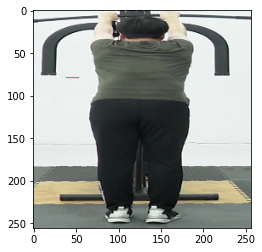

In [17]:
img_np = denormalize(img)
plt.imshow(img_np)

In [18]:
phmap = model(img.unsqueeze(0).cuda())

In [19]:
pkey = utils.heatmaps2keypoints(phmap[0]).cpu()

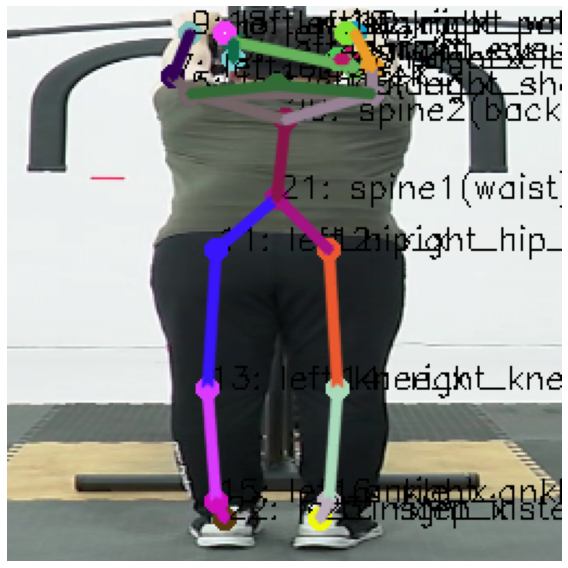

In [20]:
utils.draw_keypoints_show(img_np, pkey * 4)

In [21]:
phmap = model(img.unsqueeze(0).cuda())

In [22]:
if ds_tests[0].horizontal_flip:
    phmap = torch.flip(phmap, (3,))
if ds_tests[0].vertical_flip:
    phmap = torch.flip(phmap, (2,))
phmap = F.interpolate(phmap, ori_size[::-1])
if ds_tests[0].rotation > 0:
    phmap = torch.rot90(phmap, 4 - ds_tests[0].rotation, (2, 3))

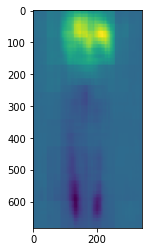

In [23]:
plt.imshow(phmap[0, 0].cpu())

In [24]:
img_ori = imageio.imread(file)

In [25]:
pkey = utils.heatmaps2keypoints(phmap[0]).cpu()

In [26]:
pkey[:, 0] += offset[0]
pkey[:, 1] += offset[1]

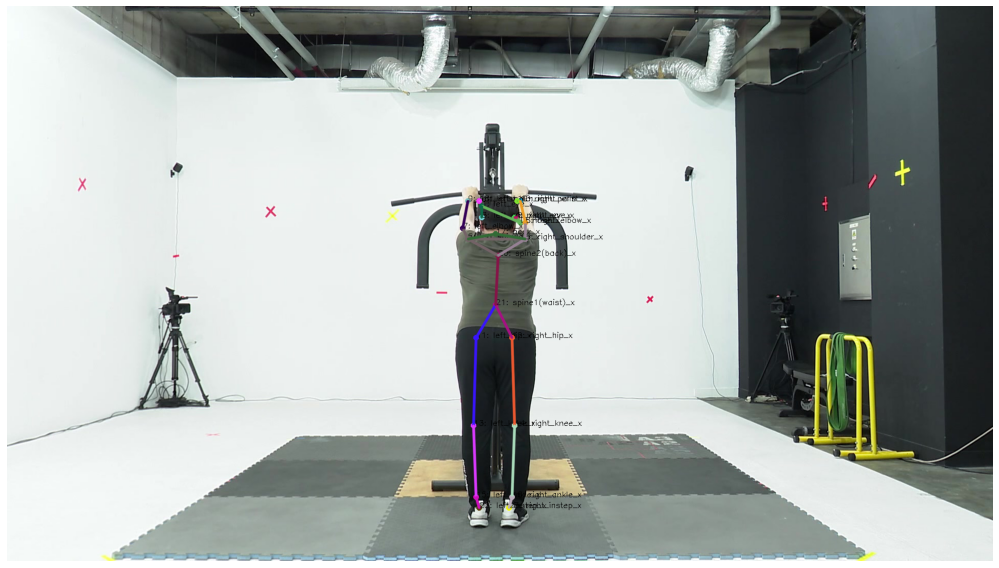

In [27]:
utils.draw_keypoints_show(img_ori, pkey)

## votion 실험

In [15]:
swap_columns = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16), (18, 19), (22, 23)]

In [16]:
# sizes = [(256, 256), (512, 512), (768, 768)]
sizes = [(256, 256), (512, 512)]
# sizes = [(256, 256)]
# sizes = [(512, 512)]
# sizes = [(768, 768)]
rotations = [0, 1, 2, 3]
# rotations = [0]
vflips = [False, True]
# vflips = [False]
hflips = [False, True]
# hflips = [False]

ds_tests = [
    TestKeypointDataset(
        img_files,
        info,
        normalize=True,
        mean=C.dataset.mean,
        std=C.dataset.std,
        size=size,
        rotation=rotation,
        horizontal_flip=hflip,
        vertical_flip=vflip,
        ratio_limit=C.dataset.ratio_limit,
    )
    for size in sizes
    for rotation in rotations
    for vflip in vflips
    for hflip in hflips
]
len(ds_tests)

32

In [30]:
with tqdm(total=L, ncols=100, file=sys.stdout) as t:
    for i in range(L):
        i = 713
        phmaps = []
        for ds_test in ds_tests:
            file, img, offset, ratio, ori_size = ds_test[i]
            file = Path(file)
            t.set_postfix_str(file.name)

            phmap = model(img.unsqueeze(0).cuda())
            if ds_test.horizontal_flip:
                phmap = torch.flip(phmap, (3,))
                for a, b in swap_columns:
                    temp = phmap[:, a].clone()
                    phmap[:, a] = phmap[:, b]
                    phmap[:, b] = temp
            if ds_test.vertical_flip:
                phmap = torch.flip(phmap, (2,))
                for a, b in swap_columns:
                    temp = phmap[:, a].clone()
                    phmap[:, a] = phmap[:, b]
                    phmap[:, b] = temp
            phmap = F.interpolate(phmap, ori_size[::-1])
            if ds_test.rotation > 0:
                phmap = torch.rot90(phmap, 4 - ds_test.rotation, (2, 3))
            phmaps.append(phmap)
        phmaps = torch.cat(phmaps)
        break

        t.update()

  0%|                                        | 0/1600 [00:01<?, ?it/s, 729-3-5-36-Z94_E-0000019.jpg]


In [31]:
img_ori = imageio.imread(file)

### Gamma Correction

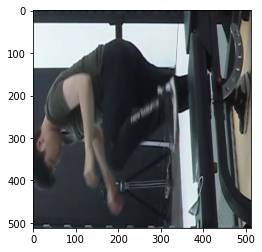

In [32]:
plt.imshow(denormalize(img))

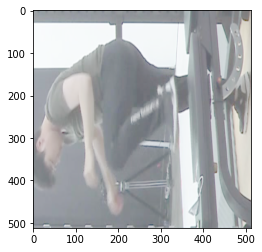

In [33]:
plt.imshow((denormalize(img) / 255) ** 0.3)

In [34]:
img_gamma = (denormalize(img) / 255) ** 0.5

In [35]:
mean = torch.tensor(C.dataset.mean, dtype=torch.float).view(3, 1, 1)
std = torch.tensor(C.dataset.std, dtype=torch.float).view(3, 1, 1)

In [36]:
img_gamma_ = (torch.tensor(img_gamma, dtype=torch.float).permute(2, 0, 1) - mean) / std

In [37]:
ghmap = model(img_gamma_.unsqueeze(0).cuda())

In [38]:
gkey = utils.heatmaps2keypoints(ghmap) * 4

In [39]:
img_gamma_np = (img_gamma * 255).astype(np.uint8)

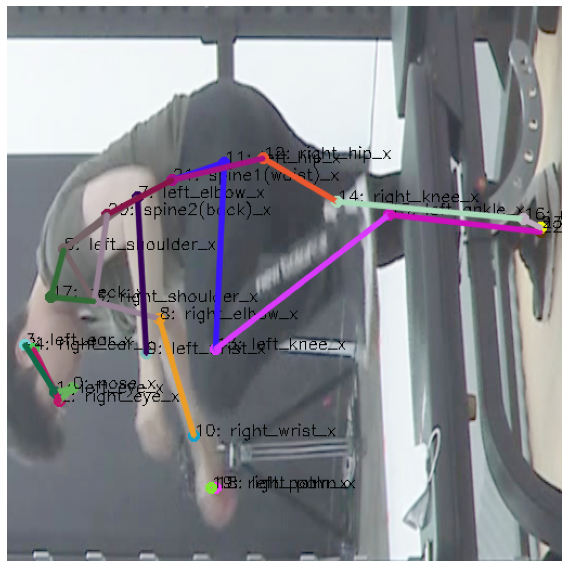

In [40]:
utils.draw_keypoints_show(img_gamma_np, gkey[0])

In [41]:
phmap = model(img.unsqueeze(0).cuda())

In [42]:
pkey = utils.heatmaps2keypoints(phmap)

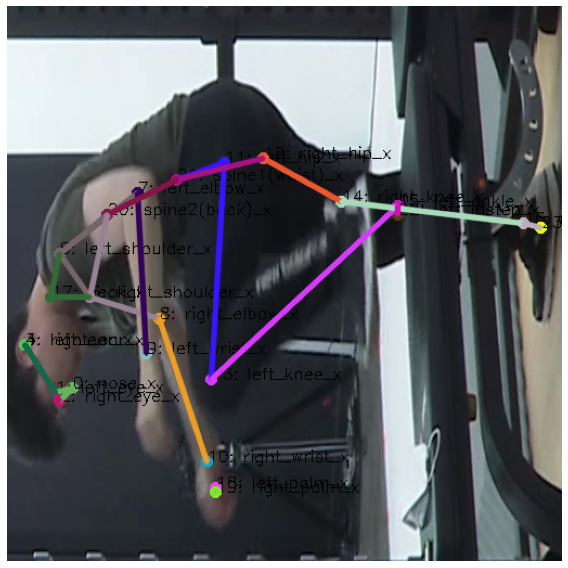

In [43]:
utils.draw_keypoints_show(denormalize(img), pkey[0].cpu() * 4)

생각보다 효과가 없다;; cross entropy를 우선하자

### 단순 평균

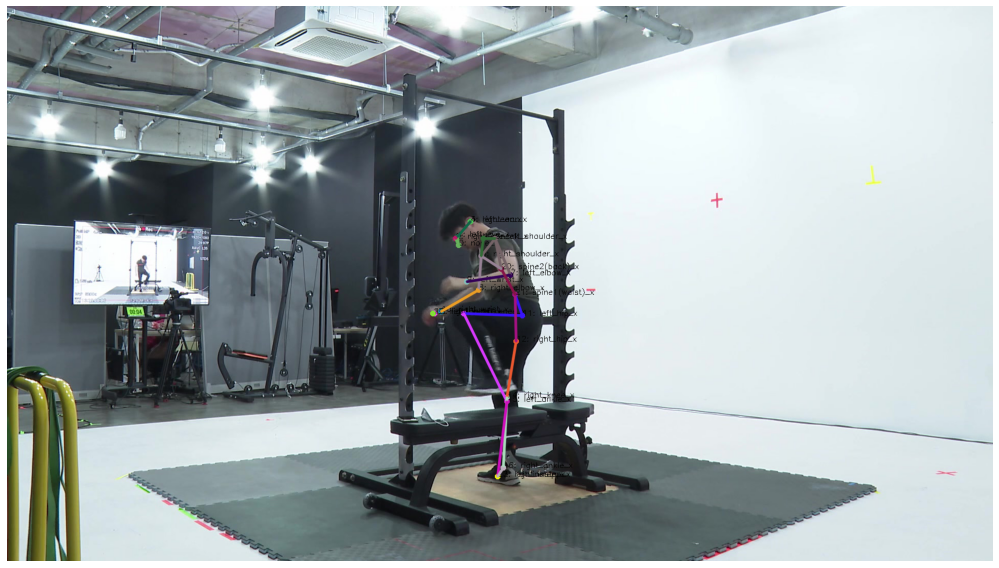

In [44]:
phmap = phmaps.mean(0).cpu()
pkey = utils.heatmaps2keypoints(phmap).cpu()
pkey[:, 0] += offset[0]
pkey[:, 1] += offset[1]
utils.draw_keypoints_show(img_ori, pkey)

### 키포인트 평균

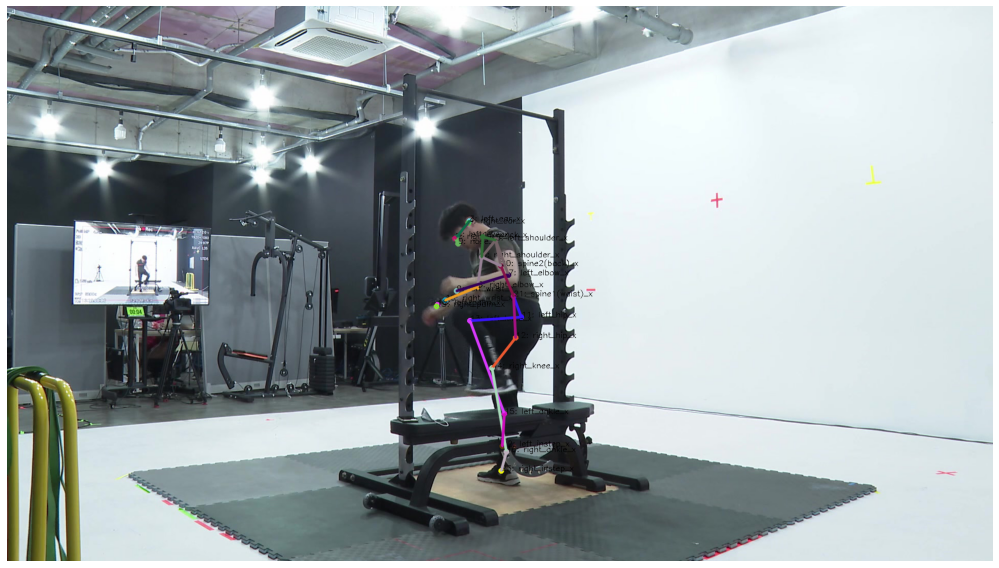

In [45]:
pkeys = utils.heatmaps2keypoints(phmaps)
pkey = pkeys.mean(0).cpu()
pkey[:, 0] += offset[0]
pkey[:, 1] += offset[1]
utils.draw_keypoints_show(img_ori, pkey)

### 키포인트 중간값

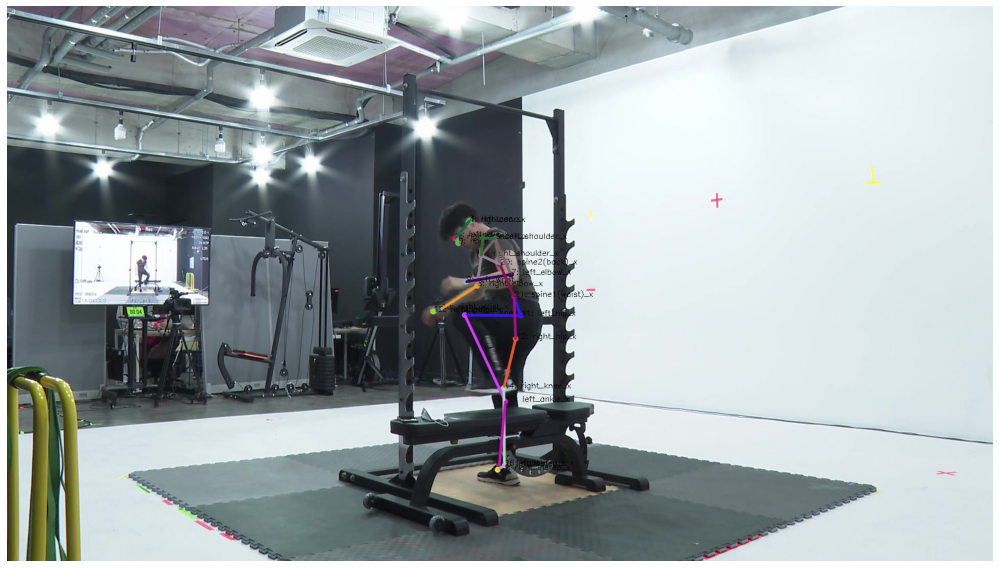

In [46]:
pkeys = utils.heatmaps2keypoints(phmaps)
pkey = pkeys.median(0).values.cpu()
pkey[:, 0] += offset[0]
pkey[:, 1] += offset[1]
utils.draw_keypoints_show(img_ori, pkey)

## test데이터 voting 방법들 모두 이미지로 저장

In [17]:
# outdir1 = Path("results/hrnet-train2/example/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau/test_simple_mean")
# outdir2 = Path("results/hrnet-train2/example/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau/test_key_mean")
outdir3 = Path("results/hrnet-train2/example/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau/test_key_median_4")
# outdir1.mkdir(parents=True, exist_ok=True)
# outdir2.mkdir(parents=True, exist_ok=True)
outdir3.mkdir(parents=True, exist_ok=True)

In [18]:
pkey_list = []
with tqdm(total=L, ncols=100, file=sys.stdout) as t:
    for i in range(L):
        phmaps = []
        for ds_test in ds_tests:
            file, img, offset, ratio, ori_size = ds_test[i]
            file = Path(file)
            t.set_postfix_str(file.name)

            phmap = model(img.unsqueeze(0).cuda())
            if ds_test.horizontal_flip:
                phmap = torch.flip(phmap, (3,))
                for a, b in swap_columns:
                    temp = phmap[:, a].clone()
                    phmap[:, a] = phmap[:, b]
                    phmap[:, b] = temp
            if ds_test.vertical_flip:
                phmap = torch.flip(phmap, (2,))
                for a, b in swap_columns:
                    temp = phmap[:, a].clone()
                    phmap[:, a] = phmap[:, b]
                    phmap[:, b] = temp
            phmap = F.interpolate(phmap, ori_size[::-1])
            if ds_test.rotation > 0:
                phmap = torch.rot90(phmap, 4 - ds_test.rotation, (2, 3))
            phmaps.append(phmap)
        phmaps = torch.cat(phmaps)

        img_ori = imageio.imread(file)

        # 키포인트 중간값
        pkeys = utils.heatmaps2keypoints(phmaps)
        pkey = pkeys.median(0).values.cpu()
        pkey[:, 0] += offset[0]
        pkey[:, 1] += offset[1]
        pkey_list.append(pkey)
        imout = utils.draw_keypoints(img_ori, pkey)
        imageio.imwrite(outdir3 / f"{i:04d}-{file.name}", imout)

        t.update()

100%|█████████████████████████████| 1600/1600 [45:59<00:00,  1.72s/it, 786-3-5-41-Z94_E-0000031.jpg]


TODO: phmap도 저장하자

## keypoint들을 csv로 저장

In [19]:
pkey_list_ = torch.stack(pkey_list)

In [20]:
np.savez_compressed(
    "results/hrnet-train2/example/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau/256x256,512x512_4.npz",
    keypoints=pkey_list_.numpy(),
)

In [21]:
len(img_files)

1600

In [22]:
sample_submission = pd.read_csv("data/ori/sample_submission.csv")

In [23]:
images = np.array(list(map(lambda x: x.name, img_files)))

In [24]:
np.expand_dims(images, 1).shape

(1600, 1)

In [25]:
keys_out = pkey_list_.flatten(1).numpy()
keys_out.shape

(1600, 48)

In [26]:
df = np.concatenate([np.expand_dims(images, 1), keys_out], 1)

In [27]:
sample_submission.columns[1:]

Index(['nose_x', 'nose_y', 'left_eye_x', 'left_eye_y', 'right_eye_x',
       'right_eye_y', 'left_ear_x', 'left_ear_y', 'right_ear_x', 'right_ear_y',
       'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x',
       'right_shoulder_y', 'left_elbow_x', 'left_elbow_y', 'right_elbow_x',
       'right_elbow_y', 'left_wrist_x', 'left_wrist_y', 'right_wrist_x',
       'right_wrist_y', 'left_hip_x', 'left_hip_y', 'right_hip_x',
       'right_hip_y', 'left_knee_x', 'left_knee_y', 'right_knee_x',
       'right_knee_y', 'left_ankle_x', 'left_ankle_y', 'right_ankle_x',
       'right_ankle_y', 'neck_x', 'neck_y', 'left_palm_x', 'left_palm_y',
       'right_palm_x', 'right_palm_y', 'spine2(back)_x', 'spine2(back)_y',
       'spine1(waist)_x', 'spine1(waist)_y', 'left_instep_x', 'left_instep_y',
       'right_instep_x', 'right_instep_y'],
      dtype='object')

In [28]:
df = pd.DataFrame(df, columns=sample_submission.columns)

In [29]:
df

image  nose_x nose_y left_eye_x left_eye_y  \
0     649-2-4-32-Z148_A-0000001.jpg  1100.0  519.0     1099.0      541.0   
1     649-2-4-32-Z148_A-0000003.jpg  1103.0  517.0     1099.0      539.0   
2     649-2-4-32-Z148_A-0000005.jpg  1101.0  520.0     1101.0      539.0   
3     649-2-4-32-Z148_A-0000007.jpg  1088.0  525.0     1108.0      544.0   
4     649-2-4-32-Z148_A-0000009.jpg  1097.0  522.0     1097.0      538.0   
...                             ...     ...    ...        ...        ...   
1595   786-3-5-41-Z94_E-0000023.jpg   715.0  583.0      715.0      571.0   
1596   786-3-5-41-Z94_E-0000025.jpg   940.0  615.0      938.0      598.0   
1597   786-3-5-41-Z94_E-0000027.jpg   734.0  602.0      734.0      582.0   
1598   786-3-5-41-Z94_E-0000029.jpg   865.0  591.0      857.0      574.0   
1599   786-3-5-41-Z94_E-0000031.jpg   933.0  615.0      932.0      600.0   

     right_eye_x right_eye_y left_ear_x left_ear_y right_ear_x  ...  \
0         1121.0       531.0     1070.0      590.0      1153.0  ...   
1         1121.0       532.0     1070.0      591.0      1153.0  ...   
2         1122.0       532.0     1069.0      591.0      1150.0  ...   
3         1109.0       537.0     1099.0      590.0      1099.0  ...   
4         1117.0       530.0     1067.0      592.0      1143.0  ...   
...          ...         ...        ...        ...         ...  ...   
1595       725.0       574.0      676.0      556.0       703.0  ...   
1596       949.0       607.0      918.0      576.0       939.0  ...   
1597       746.0       588.0      705.0      564.0       727.0  ...   
1598       870.0       581.0      823.0      563.0       852.0  ...   
1599       940.0       606.0      905.0      578.0       929.0  ...   

     right_palm_x right_palm_y spine2(back)_x spine2(back)_y spine1(waist)_x  \
0           987.0        295.0          971.0          535.0           903.0   
1           987.0        294.0          971.0          535.0           904.0   
2          1053.0        277.0          970.0          542.0           902.0   
3          1272.0        559.0          965.0          527.0           907.0   
4          1109.0        292.0          958.0          541.0           898.0   
...           ...          ...            ...            ...             ...   
1595        750.0        687.0          650.0          669.0           671.0   
1596       1061.0        727.0          859.0          668.0           859.0   
1597        853.0        702.0          658.0          684.0           677.0   
1598        994.0        714.0          781.0          675.0           797.0   
1599       1051.0        736.0          842.0          663.0           829.0   

     spine1(waist)_y left_instep_x left_instep_y right_instep_x right_instep_y  
0              519.0         678.0         699.0          825.0          651.0  
1              520.0         679.0         697.0          826.0          652.0  
2              523.0         677.0         696.0          828.0          651.0  
3              510.0         677.0         697.0          816.0          653.0  
4              522.0         679.0         693.0          827.0          652.0  
...              ...           ...           ...            ...            ...  
1595           751.0         944.0         856.0          988.0          850.0  
1596           749.0         944.0         872.0          995.0          851.0  
1597           764.0         949.0         872.0          987.0          852.0  
1598           759.0         942.0         878.0          991.0          860.0  
1599           739.0         943.0         851.0          990.0          857.0  

[1600 rows x 49 columns]

In [30]:
df.to_csv(
    "results/hrnet-train2/example/HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau/"
    + "HRNet-W48-ce-512x512-plus_augment-maw-rr2.0-ReduceLROnPlateau-256x256_512x512_4.csv",
    index=False,
)